In [1]:
import sys
import subprocess
import os 

import glob
import multiprocessing

In [2]:
sys.path.append('../../')
from extract_glycan_info import parse_gf_result

Script: Find glycosidic dihedral, average B-factor, and ring shape of glycans from PDB
Author:Rajan Kandel <rajan.kandel@uga.edu>
      *Woods Group, CCRC UGA
  
Currently under development.......
Last Update: Oct 2024

Citations:
1. https://glycam.org/cb/
2. https://glycam.org/portal/gf_home/
 


In [3]:
phi_dihedral=['C2','C1','O3','C3']
psi_dihedral=['C1','O3','C3','C4']

di_sugar=['GLA', 'NDG']
patterns1= ['GLA(*_*_)]-NDG(*_*_)', 'GLA(*_*_)-NDG(*_*_)','GLA(*_*_)]-[*]-NDG(*_*_)', 'GLA(*_*_)-[*]-NDG(*_*_)']
patterns2= ['DGalpa1-3DGlcpNAca', 'DGalpa1-3]DGlcpNAca', 'DGalpa1-3[*]DGlcpNAca']
patterns=(patterns1,patterns2)

gf_result ='../../data_gf_query/a1-3D_GF_results.csv'

chimerax_path= '/bin/chimerax'
bfmp_path = '/home/rajan/apps/BFMP/detect_shape'


instant1 = parse_gf_result(gf_result, phi_dihedral, psi_dihedral, di_sugar, patterns, chimerax_path, bfmp_path)
instant1.read_gf_file()
instant1.dnl_pdbs()
instant1.create_pdb_glycan_dict() 
instant1.glycan_count()
instant1.select_pdbs()

========== Reading_gf_results =====================================
pdbs: ['146D', '146D', '1A14', '1ABR', '1ABR', '1AGM', '1AGM', '1AX0', '1AX1', '1AX2', '1AXY', '1AXZ', '1AY2', '1B37', '1B5F', '1B5F', '1B5F', '1B5F', '1B5Q', '1BCS', '1BHG', '1BHG', '1BJI', '1BLF', '1BP8', '1BP8', '1BP8', '1BP8', '1BZB', '1C1Z', '1C39', '1C39', '1C3M', '1CAP', '1CF3', '1CKL', '1CKL', '1CKL', '1CKL', '1CKL', '1CKL', '1CLY', '1CLZ', '1CP8', '1CP8', '1CPO', '1CT1', '1CT1', '1CVI', '1CVI', '1CVI', '1CVN', '1CVN', '1CVN', '1CVN', '1CXP', '1CXP', '1D2V', '1D2V', '1D5L', '1D5L', '1D7W', '1D7W', '1D83', '1D83', '1DBG', '1DBO', '1DEO', '1DEX', '1DGL', '1DGL', '1DIY', '1DL2', '1DN2', '1DN2', '1DNU', '1DNU', '1DNW', '1DNW', '1DOG', '1DOG', '1DP5', '1DPJ', '1DWA', '1DWA', '1DWF', '1DWF', '1DWG', '1DWG', '1DWH', '1DWH', '1DWI', '1DWI', '1DWJ', '1DWJ', '1DZH', '1E04', '1E05', '1E4K', '1E4K', '1E4M', '1E4M', '1E6Q', '1E6Q', '1E6S', '1E6S', '1E6X', '1E6X', '1E70', '1E70', '1E71', '1E71', '1E72', '1E72', '1E73', '1E73

In [4]:
%%capture output
instant1.generate_chimerax_script_to_compute_dihedral()

In [5]:
# Write the entire output to a file
with open('calc_dihedral2.cxc', 'w') as f:
    f.write(output.stdout)

In [6]:
# Use the custom split function
instant1.custom_split_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral_part_')

chimerax script is run parallely in ./calc_dihedral_chimerax
Split into 1 files.


In [7]:
# Run the parallel execution and stitching
instant1.run_chimerax_script_parallel('./calc_dihedral_chimerax/calc_dihedral_part_*.cxc')

Executed 1 ChimeraX scripts in parallel.
Combined outputs into:  combined_chimerax_output.out


In [8]:
# instant1.run_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral2.out')

In [9]:
# torsions = instant1.clean_up_chimerax_output('calc_dihedral2.out')
torsions = instant1.clean_up_chimerax_output('combined_chimerax_output.out')
torsions.to_csv('chimerax_output.csv', index=False)

number of pdb read: 4 
valid torsion1 and torsion2: (4, 4)


In [10]:
instant1.calc_BFactor()

In [11]:
instant1.find_bfmp_ring_shape()

(['2.B', '1.B'], ['4C1', '4C1'])
(['2.B', '1.B'], ['4C1', '4C1'])
(['2.B', '1.B'], ['4C1', '4C1'])
(['2.B', '1.B'], ['4C1', '4C1'])


In [12]:
output_df = instant1.match_glycan_tree()

../../pdbs//4xle.pdb B GLA 2 C1
../../pdbs//4xle.pdb B NDG 1 O3
4733 4727
Connection found between 4733 and 4727
../../pdbs//4xlf.pdb B GLA 2 C1
../../pdbs//4xlf.pdb B NDG 1 O3
4673 4667
Connection found between 4673 and 4667
../../pdbs//6gvr.pdb B GLA 2 C1
../../pdbs//6gvr.pdb B NDG 1 O3
4682 4676
Connection found between 4682 and 4676
../../pdbs//6gvp.pdb B GLA 2 C1
../../pdbs//6gvp.pdb B NDG 1 O3
4653 4647
Connection found between 4653 and 4647
droped rows: []


In [13]:
output_df.to_csv('DGalpa1-3DGlcpNAca_ver2.1.csv',sep=',',index=False, columns=['pdb','glycam name','glycan','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])
output_df.to_csv('DGalpa1-3DGlcpNAca_ver3.csv',sep=',',index=False, columns=['pdb','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])

In [14]:
################################
# print(instant1.pdbs)
# print(instant1.pdb_glycan_dict)

In [15]:
instant1.torsions

,pdb,phi site,psi site,phi,psi,B factor(Avg),glycan,glycam name,BFMP ring shape
0,4xle.pdb,B GLA 2 C2 C1 NDG 1 O3 C3,B GLA 2 C1 NDG 1 O3 C3 C4,200.901,95.3547,"([GLA(2_B_), NDG(1_B_)], [12.69, 11.48])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([2.B, 1.B], [4C1, 4C1])"
1,4xlf.pdb,B GLA 2 C2 C1 NDG 1 O3 C3,B GLA 2 C1 NDG 1 O3 C3 C4,203.334,92.1299,"([GLA(2_B_), NDG(1_B_)], [12.47, 12.53])",RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA(2_B_)-NDG(...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3DGlcp...,"([2.B, 1.B], [4C1, 4C1])"
2,6gvr.pdb,B GLA 2 C2 C1 NDG 1 O3 C3,B GLA 2 C1 NDG 1 O3 C3 C4,203.379,93.9961,"([GLA(2_B_), NDG(1_B_)], [18.9, 19.37])",RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA(2_B_)-NDG(...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3DGlcp...,"([2.B, 1.B], [4C1, 4C1])"
3,6gvp.pdb,B GLA 2 C2 C1 NDG 1 O3 C3,B GLA 2 C1 NDG 1 O3 C3 C4,196.981,99.1300,"([GLA(2_B_), NDG(1_B_)], [16.43, 16.25])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([2.B, 1.B], [4C1, 4C1])"


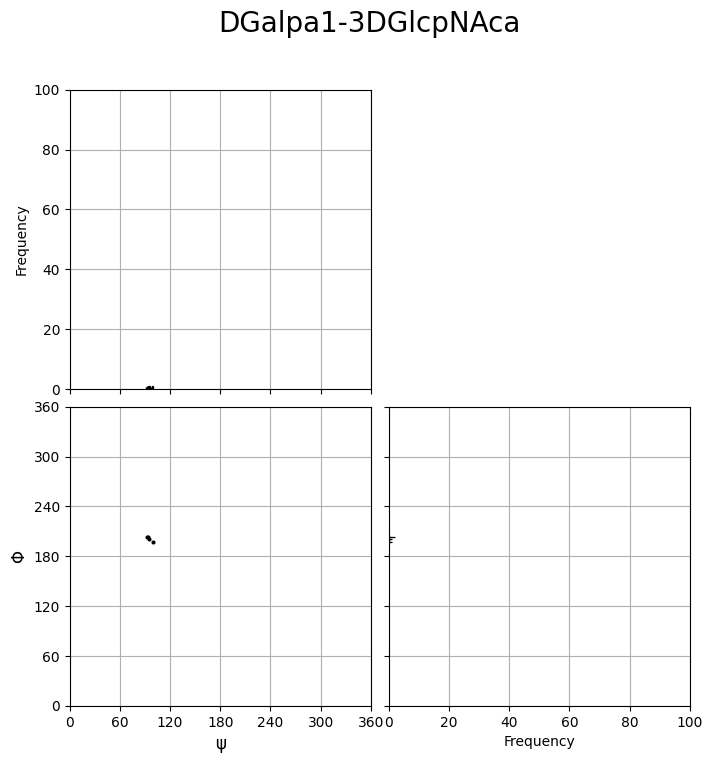

In [16]:
instant1.plot(torsions=instant1.torsions, title='DGalpa1-3DGlcpNAca',max_histogram_scale=100,step_histogram_tick=20)